In [329]:
# Loading data & Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

salarydf = pd.read_csv("NBA Player Salaries_2024-25_1.csv")
statsdf = pd.read_csv("NBA Player Stats_2024-25_Per_Game.csv")

# some stats doesn't show
pd.set_option('display.max_columns', None)

In [330]:
# Cleaning Salary Data

# Removing dollar signs from salary
salarydf['Salary'] = salarydf['Salary'].replace(r'[\$,]', '', regex=True).astype(int)

# Show and drop exact duplicate rows (all columns match)
# duplicate_rows = salarydf[salarydf.duplicated()]
# print(duplicate_rows)

salarydf = salarydf.drop_duplicates()

print(len(salarydf))

# Strip whitespace from player names
salarydf['Player'] = salarydf['Player'].str.strip()

# Check for missing/null values
print(salarydf.isnull().sum())

536
Player    0
Team      0
Salary    0
dtype: int64


In [331]:
# Cleaning Stats Data

# 1) players played for multiple teams.

# Step 1: Count how many times each player appears (find players with multiple teams)
duplicate_players = statsdf['Player'].value_counts()
multi_team_players = duplicate_players[duplicate_players > 1].index

# Step 2: Filter rows where the player is in that list (i.e., players who moved teams)
multi_team_rows = statsdf[statsdf['Player'].isin(multi_team_players)]

# Show the rows where players moved teams (to check)
print(multi_team_rows.sort_values(by='Player'))

# Step 3: Separate the single-team rows (players who stayed with one team)
single_team_rows = statsdf[~statsdf['Player'].isin(multi_team_players)]

# Step 4: Combine the single-team rows with the multi-team rows that we will keep (one row per player)
# Here, we're keeping the first row for each player in multi_team_rows (the one with '2TM', '3TM', etc.)
summary_rows = multi_team_rows.drop_duplicates(subset='Player', keep='first')

# Combine the two parts together
cleaned_statsdf = pd.concat([single_team_rows, summary_rows], ignore_index=True)

# Step 5: Show the cleaned data
print(cleaned_statsdf.sort_values(by='Player'))


      Rk        Player  Age Team Pos   G  GS    MP   FG   FGA    FG%   3P  \
331  271    AJ Johnson   20  2TM  SG  29  11  22.0  2.8   7.3  0.385  0.8   
333  271    AJ Johnson   20  WAS  SG  22  11  27.0  3.4   8.8  0.381  1.0   
332  271    AJ Johnson   20  MIL  SG   7   0   6.3  1.1   2.7  0.421  0.4   
678  521      Alex Len   31  2TM   C  46   7   8.3  0.7   1.4  0.508  0.0   
679  521      Alex Len   31  SAC   C  36   3   7.2  0.6   1.1  0.537  0.0   
..   ...           ...  ...  ...  ..  ..  ..   ...  ...   ...    ...  ...   
406  326  Zach Collins   27  2TM  PF  64  12  15.3  2.4   4.7  0.507  0.5   
408  326  Zach Collins   27  CHI  PF  28   8  19.7  3.3   6.1  0.541  0.6   
36    29   Zach LaVine   29  SAC  SG  32  32  36.6  8.2  16.0  0.511  3.2   
35    29   Zach LaVine   29  CHI  SF  42  42  34.1  8.6  16.9  0.511  3.2   
34    29   Zach LaVine   29  2TM  SF  74  74  35.2  8.4  16.5  0.511  3.2   

     3PA    3P%   2P  2PA    2P%   eFG%   FT  FTA    FT%  ORB  DRB  TRB  AS

In [332]:
# 2) check for missing/null values:

cleaned_statsdf = cleaned_statsdf.fillna(0)
print(cleaned_statsdf.isnull().sum())

# 3) Strip potential whitespaces in player names

cleaned_statsdf['Player'] = cleaned_statsdf['Player'].str.strip()

# 4) Remove 'Rk' column

cleaned_statsdf = cleaned_statsdf.drop(columns=['Rk'], errors='ignore')


Rk        0
Player    0
Age       0
Team      0
Pos       0
G         0
GS        0
MP        0
FG        0
FGA       0
FG%       0
3P        0
3PA       0
3P%       0
2P        0
2PA       0
2P%       0
eFG%      0
FT        0
FTA       0
FT%       0
ORB       0
DRB       0
TRB       0
AST       0
STL       0
BLK       0
TOV       0
PF        0
PTS       0
dtype: int64


In [333]:
# Merge the datasets

# Merge on 'Player'
stats_salary = pd.merge(cleaned_statsdf, salarydf[['Player', 'Salary']], on='Player', how='inner')

# Show the first few rows
print(stats_salary.head())

                    Player  Age Team Pos   G  GS    MP    FG   FGA    FG%  \
0  Shai Gilgeous-Alexander   26  OKC  PG  76  76  34.2  11.3  21.8  0.519   
1    Giannis Antetokounmpo   30  MIL  PF  67  67  34.2  11.8  19.7  0.601   
2             Nikola Jokic   29  DEN   C  70  70  36.7  11.2  19.5  0.576   
3          Anthony Edwards   23  MIN  SG  79  79  36.3   9.1  20.4  0.447   
4             Jayson Tatum   26  BOS  PF  72  72  36.4   9.2  20.3  0.452   

    3P   3PA    3P%    2P   2PA    2P%   eFG%   FT   FTA    FT%  ORB  DRB  \
0  2.1   5.7  0.375   9.2  16.1  0.571  0.569  7.9   8.8  0.898  0.9  4.1   
1  0.2   0.9  0.222  11.6  18.7  0.620  0.607  6.5  10.6  0.617  2.2  9.7   
2  2.0   4.7  0.417   9.3  14.8  0.627  0.627  5.2   6.4  0.800  2.9  9.9   
3  4.1  10.3  0.395   5.1  10.1  0.501  0.547  5.3   6.3  0.837  0.8  4.9   
4  3.5  10.1  0.343   5.7  10.2  0.559  0.537  5.0   6.1  0.814  0.7  8.0   

    TRB   AST  STL  BLK  TOV   PF   PTS    Salary  
0   5.0   6.4  1.7  1.

In [334]:
# Show Correlation (Numbers)

# Compute correlation with Salary
correlations = stats_salary.corr(numeric_only=True)['Salary'].sort_values(ascending=False)

print(correlations)

Salary    1.000000
PTS       0.737977
FG        0.729211
FGA       0.709757
FT        0.697531
FTA       0.680152
2PA       0.679644
2P        0.670809
MP        0.647724
TOV       0.633619
GS        0.614232
AST       0.612352
DRB       0.543936
3P        0.496067
3PA       0.493825
TRB       0.474727
STL       0.470319
PF        0.389425
Age       0.313994
G         0.292012
BLK       0.234973
FT%       0.232981
ORB       0.213054
FG%       0.155985
eFG%      0.139861
3P%       0.132112
2P%       0.090879
Name: Salary, dtype: float64


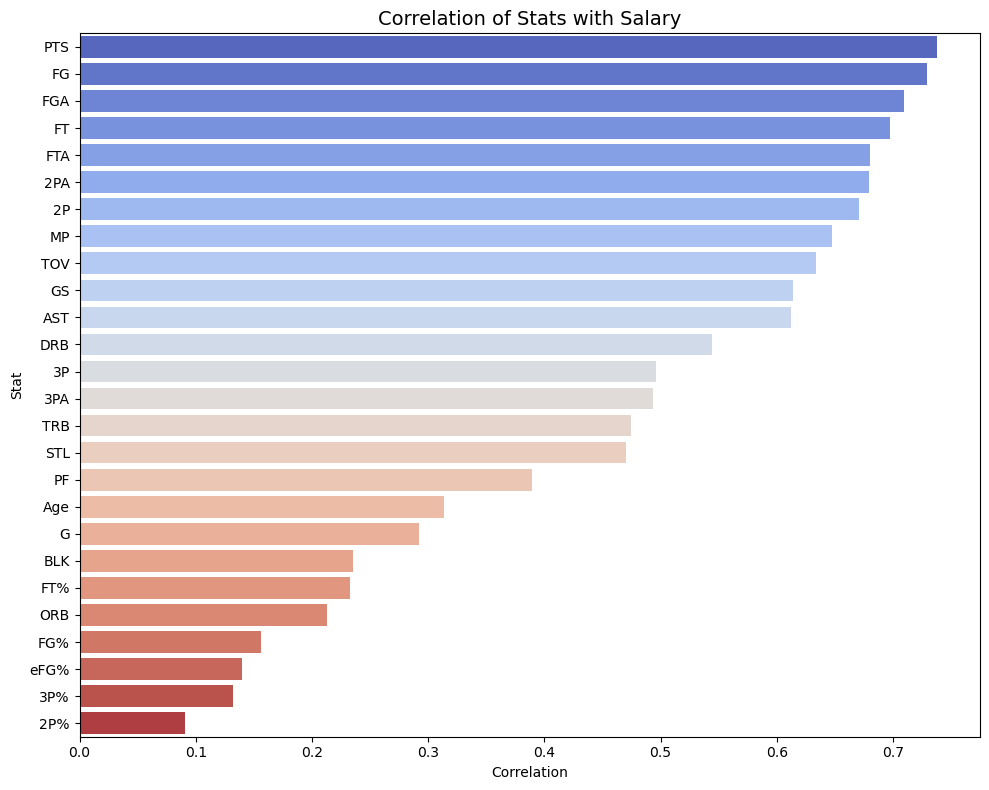

In [335]:
# Show Correlation (Barplot)

# Filter only numeric columns
numeric_df = stats_salary.select_dtypes(include='number')

# Correlation with Salary
salary_corr = numeric_df.corr()['Salary'].drop('Salary').sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(
    x=salary_corr.values,
    y=salary_corr.index,
    hue=salary_corr.index,
    palette="coolwarm",
    legend=False
)
plt.title("Correlation of Stats with Salary", fontsize=14)
plt.xlabel("Correlation")
plt.ylabel("Stat")
plt.tight_layout()
plt.show()

In [336]:
# Function of scatterplot comparing player's salary with various stats

stats_salary['Salary_M'] = stats_salary['Salary'] / 1e6

def plot_salary_vs_stat(stat_col):
    # Convert 'Salary' to 'Salary_M' if not already in millions
    if 'Salary_M' not in stats_salary.columns:
        stats_salary['Salary_M'] = stats_salary['Salary'] / 1e6

    # Create scatter plot with salary on X-axis
    fig = px.scatter(
        stats_salary,
        x='Salary_M',   # Now Salary is on the X-axis
        y=stat_col,     # The stat column will be on the Y-axis
        hover_data={
            'Player': True,
            stat_col: True,
            'Salary_M': ':.2f'  # Showing Salary in Millions
        },
        trendline='ols',  # Add a regression line
        title=f'Salary vs {stat_col}',  # Dynamic title
        labels={'Salary_M': 'Salary ($M)', stat_col: stat_col},  # Axis labels
        trendline_color_override='black'  # Set the color of the regression line (blue)
    )

    fig.update_traces(marker=dict(color='skyblue'))  # Change all points to red

    # Customize layout
    fig.update_layout(
        xaxis_tickprefix="$",  # Prefix for Salary
        xaxis_ticksuffix="M",  # Suffix for Salary (in millions)
        template='plotly_white'  # A clean plot template
    )
    fig.show()

In [337]:
# Scatterplots

plot_salary_vs_stat('PTS')

plot_salary_vs_stat('MP')

plot_salary_vs_stat('Age')

plot_salary_vs_stat('eFG%')

In [338]:
# Initial analysis of Correlation and building Regression Model

# 1) Efficiency Stats (FT%, FG%, eFG%, 3P%, 2P%) show low correlation to player's salary
# Potential reason: efficiency stats often higher for role-players and bench players, who often doesn't get that many opportunity to score
#                   and specialized to one ability (e.g. spot-up shooters).
# Action: will drop all of them except for eFG%, which shows low correlation to salary but combines both FG% and 3P%, which makes
#         a comprehensive indicator for scoring efficiency

# 2) Will keep traditional (volume) stats, such as PTS, AST, TRB, STL, except for BLK (shows extremely low corrleation to salary)

# 3) Reducing Multicollinearity
# 3-1) FG-FGA: directly correlated to each other, will remove FGA and keep FG
# 3-2) FT-FTA: directly correlated to each other, will remove FTA and keep FT
# 3-3) 2P-2PA: directly correlated to each other, will remove 2PA and keep 2P
# 3-4) MP-G-GS: correlated to each other, displays player's actual involvement to the team. Will remove G since shows low correlation
#               , also remove GS since MP can explain player's importance to the team, and keep MP.
# 3-5) TRB-DRB-ORB: directly correlated to each other, TRB gives overall picture about player's rebounding ability. will remove DRB/ORB and keep TRB
# 3-6) 3P-3PA: correlated to FG, will remove both 3P and 3PA and keep FG

# 4) Moderate/low correlation, but...
#    will keep TOV since it likely has negative correlation to player's salary (more turnovers = less money)
#    will keep age since it is interesting to see whether age plays a role on player's salary, not only performance.


# Keeping: PTS > FG > FT > 2P > MP > TOV > AST > TRB > STL > AGE > eFG%

In [339]:
# Plain Regression Model

# Define selected features
selected_features = ['PTS', 'FG', 'FT', '2P', 'MP', 'TOV', 'AST', 'TRB', 'STL', 'Age', 'eFG%']

# Split data
X = stats_salary[selected_features]
y = stats_salary['Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit plain linear regression
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)

# Get the coefficients (scaled)
coefficients = pd.Series(linreg.coef_, index=selected_features)

# Convert coefficients to dollar terms and format them
coefficients_in_dollars = coefficients.apply(lambda x: "${:,.0f}".format(x))

# Display coefficients in a readable format
print("Coefficients (Salary Change per Unit Increase):\n", coefficients_in_dollars)


Coefficients (Salary Change per Unit Increase):
 PTS     $-3,276,693
FG      $11,734,314
FT       $4,853,241
2P      $-3,778,044
MP      $-1,204,791
TOV     $-1,106,109
AST      $1,350,743
TRB      $1,431,034
STL        $-19,068
Age      $2,878,202
eFG%      $-450,787
dtype: object


In [340]:
# First Adjustment

# 1) PTS is also Highly correlated to FG, FT, 2P, EFG%. Simply, more FG/FT/2P and higher EFG% makes up higher PTS. Thus multicollinearity is caused.
# Problem: PTS is negatively correlated to salary, which doesn't makes sense. But FG/FT has positive coefficient.
#          This is happening since linear regression is "giving credit" of positive FG/FT to negative PTS/FT coefficient (tradeoff)
# Adjustment: first remove FG, FT, 2P, EFG% since PTS can (directly/indirectly) explain them all.

In [345]:
# Plain Regression Model 2

# Define selected features
selected_features_2 = ['PTS', 'MP', 'TOV', 'AST', 'TRB', 'STL', 'Age']

# Split data
X_2 = stats_salary[selected_features2]
y_2 = stats_salary['Salary']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled_2 = scaler.fit_transform(X_train_2)
X_test_scaled_2 = scaler.transform(X_test_2)

# Fit plain linear regression
linreg_2 = LinearRegression()
linreg_2.fit(X_train_scaled_2, y_train_2)

# Get the coefficients (scaled)
coefficients_2 = pd.Series(linreg.coef_, index=selected_features_2)

# Convert coefficients to dollar terms and format them
coefficients_in_dollars = coefficients_2.apply(lambda x: "${:,.0f}".format(x))

# Display coefficients in a readable format
print("Coefficients (Salary Change per Unit Increase):\n", coefficients_in_dollars)

Coefficients (Salary Change per Unit Increase):
 PTS     $9,589,783
MP     $-2,142,834
TOV      $-544,254
AST     $1,506,594
TRB     $1,247,115
STL        $-7,474
Age     $2,900,154
dtype: object


In [347]:
# TESTING

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on the test set
y_pred_2 = linreg.predict(X_test_scaled_2)

# Evaluation metrics
mse = mean_squared_error(y_test_2, y_pred_2)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_2, y_pred_2)

print("--- Plain Linear Regression ---")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"R-squared (R²): {r2:.4f}")


--- Plain Linear Regression ---
Mean Squared Error (MSE): 74,323,038,271,342.59
Root Mean Squared Error (RMSE): 8,621,081.04
R-squared (R²): 0.5529


In [349]:
# Predicting Function

def predict_salary(player_name, model, scaler, X_source, full_df):
    # Filter the row for the given player
    player_row = full_df[full_df['Player'] == player_name]

    if player_row.empty:
        print(f"Player '{player_name}' not found.")
        return

    # Extract the feature columns
    player_features = player_row[X_source.columns]

    # Scale the features
    scaled_features = scaler.transform(player_features)

    # Predict the salary
    predicted_salary = model.predict(scaled_features)[0]

    # Get the actual salary
    actual_salary = player_row['Salary'].values[0]

    # Calculate the deficit
    deficit = predicted_salary - actual_salary

    print(f"Predicted salary for {player_name}: ${predicted_salary:,.2f}")
    print(f"Current salary for {player_name}: ${actual_salary:,.2f}")
    print(f"Deficit: ${deficit:,.2f}\n")


In [351]:
# Test with favorite players
# predict_salary("Nikola Jokic", linreg, scaler, X_train, stats_salary)
# predict_salary("Stephen Curry", linreg, scaler, X_train, stats_salary)
# predict_salary("LeBron James", linreg, scaler, X_train, stats_salary)


print("Players with contract expiring next year\n")
predict_salary("James Harden", linreg_2, scaler, X_train_2, stats_salary)
predict_salary("LeBron James", linreg_2, scaler, X_train_2, stats_salary)
predict_salary("Clint Capela", linreg_2, scaler, X_train_2, stats_salary)
predict_salary("Chris Paul", linreg_2, scaler, X_train_2, stats_salary)
predict_salary("Ty Jerome", linreg_2, scaler, X_train_2, stats_salary)
predict_salary("Jaxson Hayes", linreg_2, scaler, X_train_2, stats_salary)

Players with contract expiring next year

Predicted salary for James Harden: $36,330,105.52
Current salary for James Harden: $33,653,846.00
Deficit: $2,676,259.52

Predicted salary for LeBron James: $43,158,989.92
Current salary for LeBron James: $48,728,845.00
Deficit: $-5,569,855.08

Predicted salary for Clint Capela: $13,188,778.76
Current salary for Clint Capela: $22,265,280.00
Deficit: $-9,076,501.24

Predicted salary for Chris Paul: $19,203,220.84
Current salary for Chris Paul: $10,460,000.00
Deficit: $8,743,220.84

Predicted salary for Ty Jerome: $15,329,868.13
Current salary for Ty Jerome: $2,560,975.00
Deficit: $12,768,893.13

Predicted salary for Jaxson Hayes: $4,579,832.33
Current salary for Jaxson Hayes: $2,463,946.00
Deficit: $2,115,886.33

